<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**:Mahdi ZInati

**Student ID**:400101323


# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.

2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

3) How do we classify new data points using the optimal weights and bias?

<font color='green'>Write down your answers as markdown here.</font>

Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [2]:
!pip install cvxpy

  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/37/c0/6a374faad5f62deb0613477b165ffa91353caf85fffe7e7dc7b81ba2c144/cvxpy-1.5.2-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/af/5e/0af6800c2f6afe4b8fbcde30f8135de1c5cb77b313afb8942bda2645f146/osqp-0.6.7.post0-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 301.5 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for clarabel>=0.5.0 from https://files.pythonhosted.org/packages/8b/b9/e41f5316a2d4261c340d9fa6aa1694dd57d12cc45f1e5dfc5773d2b53d39/clarabel-0.9.0-cp37-abi3-macosx_10_12_x86_64.macosx_11_0_arm64.macosx_10_12_universal2.whl.metadata
  Obtaining dependency information for scs>=3.2.4.post1 from https:/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [5]:
df1 = pd.read_csv('DF1.csv')
df2 = pd.read_csv('DF2.csv')
df3 = pd.read_csv('DF3.csv')
print("Dataset 1 (DF1.csv):")
print(df1.head())
print("\nDataset 2 (DF2.csv):")
print(df2.head())
print("\nDataset 3 (DF3.csv):")
print(df3.head())

Dataset 1 (DF1.csv):
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1

Dataset 2 (DF2.csv):
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1

Dataset 3 (DF3.csv):
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1


Use the following function to visualize the datapoints for all datasets.

DF1 Columns:
Index(['x1', 'x2', 'y'], dtype='object')

DF2 Columns:
Index(['x1', 'x2', 'y'], dtype='object')

DF3 Columns:
Index(['x1', 'x2', 'y'], dtype='object')
First Dataset:


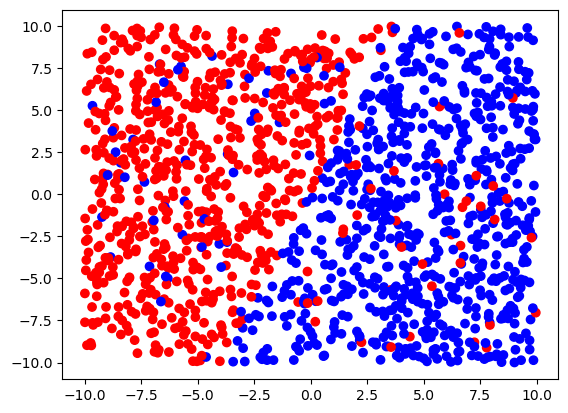

Second Dataset:


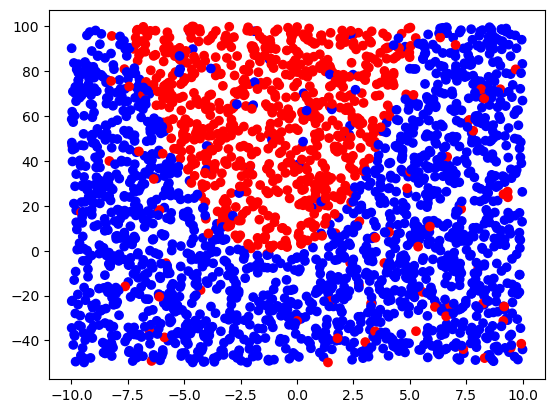

Third Dataset:


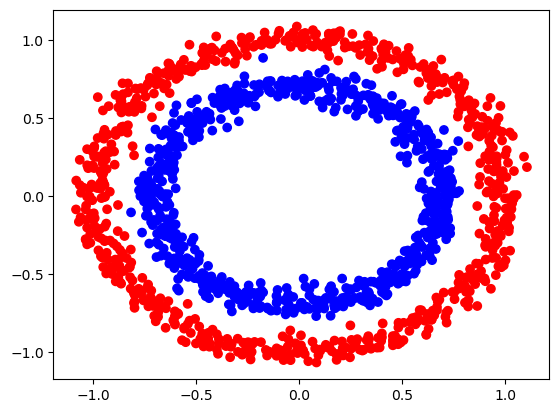

In [9]:
def visualize_data(X, y):
    col = []
    for i in range(len(y)):
        if y[i] == 1:
            col.append('red')
        else:
            col.append('blue')
    plt.scatter(X[:, 0], X[:, 1], color=col)
    plt.show()

dataset1 = pd.read_csv('DF1.csv')
dataset2 = pd.read_csv('DF2.csv')
dataset3 = pd.read_csv('DF3.csv')

print("DF1 Columns:")
print(dataset1.columns)
print("\nDF2 Columns:")
print(dataset2.columns)
print("\nDF3 Columns:")
print(dataset3.columns)

features1 = dataset1[['x1', 'x2']].values
targets1 = dataset1['y'].values
features2 = dataset2[['x1', 'x2']].values
targets2 = dataset2['y'].values
features3 = dataset3[['x1', 'x2']].values
targets3 = dataset3['y'].values

print("First Dataset:")
visualize_data(features1, targets1)
print("Second Dataset:")
visualize_data(features2, targets2)
print("Third Dataset:")
visualize_data(features3, targets3)


**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer.

Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

### Dataset 1
**Characteristics:** This dataset ranges from small to medium in size, making it ideal for scenarios where Gaussian kernels typically excel. The features likely exhibit a nonlinear relationship with the target variable. There is no significant prior information suggesting any particular structure within the data.

**Kernel:** The Gaussian (RBF) kernel is chosen for its versatility and strong performance in the absence of specific structural information. This kernel is particularly adept at capturing intricate, nonlinear relationships between features and the target variable. Given the lack of detailed structural knowledge and the common practice in typical machine learning contexts, the Gaussian kernel is a robust default choice for such datasets.

### Dataset 2
**Characteristics:** This dataset is characterized by its high dimensionality, indicating a large number of features. The relationships between features and the target variable may be sparse or highly intricate. There is no clear evidence suggesting whether these relationships are linear or nonlinear.

**Kernel:** The linear kernel is suitable for high-dimensional datasets where the relationships between features and the target variable can be effectively captured by linear combinations. Linear kernels are computationally efficient and can handle the potential sparsity or complexity of the data without the computational burden of more complex kernels. This makes them an excellent choice for datasets with many features.

### Dataset 3
**Characteristics:** This dataset is moderate to large in size, with features showing a complex, nonlinear relationship with the target variable. Domain knowledge suggests the presence of specific nonlinear interactions, possibly of a polynomial nature. Additionally, the dataset may contain outliers or noise that must be managed effectively.

**Kernel:** Given these characteristics, the polynomial kernel is a fitting choice. It introduces polynomial terms into the model, which allows for capturing higher-order interactions between features. This is particularly beneficial when there is domain knowledge suggesting such interactions. The polynomial kernel can handle the complexity and nonlinearity of the data, making it suitable for datasets where higher-order dependencies are expected. Additionally, it can manage noise and outliers more effectively than simpler kernels.

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [10]:
dataframe = pd.read_csv('DF1.csv')
features = dataframe.drop(columns=['y']).values
target = dataframe['y'].values
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(features, target, test_size=0.2, random_state=42)
scaler_instance = StandardScaler()
X_train_standardized = scaler_instance.fit_transform(X_train_set)
X_test_standardized = scaler_instance.transform(X_test_set)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [11]:
def compute_linear_kernel(a, b):
    return np.dot(a, b)
regularization_param = 1.0
sample_count = X_train_standardized.shape[0]
alphas = cp.Variable(sample_count)
y_train_set = y_train_set.astype(np.double)
kernel_matrix = np.zeros((sample_count, sample_count))
for i in range(sample_count):
    for j in range(sample_count):
        kernel_matrix[i, j] = compute_linear_kernel(X_train_standardized[i], X_train_standardized[j])
kernel_matrix += np.eye(sample_count) * 1e-6
P_matrix = np.outer(y_train_set, y_train_set) * kernel_matrix
P_matrix = cp.psd_wrap(P_matrix) 
objective_function = cp.Maximize(cp.sum(alphas) - cp.quad_form(alphas, P_matrix) / 2)
constraints_list = [cp.sum(cp.multiply(alphas, y_train_set)) == 0, alphas >= 0, alphas <= regularization_param]
optimization_problem = cp.Problem(objective_function, constraints_list)
optimization_problem.solve()
alpha_values = alphas.value
support_vecs = X_train_standardized[alpha_values > 1e-5]
support_labels = y_train_set[alpha_values > 1e-5]
bias_term = np.mean(support_labels - np.dot((alpha_values * y_train_set).T, kernel_matrix[:, alpha_values > 1e-5]))


Predict the class of each entry in the test set using your learned model.

In [12]:
def make_predictions(test_data, support_vecs, support_labels, alpha_values, bias_term):
    predictions = np.zeros(len(test_data))
    for i in range(len(test_data)):
        prediction_value = bias_term
        for alpha, sv, sv_y in zip(alpha_values[alpha_values > 1e-5], support_vecs, support_labels):
            prediction_value += alpha * sv_y * compute_linear_kernel(test_data[i], sv)
        predictions[i] = np.sign(prediction_value)
    return predictions

Use classification_report function (from sklearn) to get the accuracy of your model.

In [13]:
y_predictions = make_predictions(X_test_standardized, support_vecs, support_labels, alpha_values, bias_term)
print(classification_report(y_test_set, y_predictions))

              precision    recall  f1-score   support

          -1       0.92      0.93      0.92       148
           1       0.93      0.92      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [14]:
data = pd.read_csv('DF2.csv')
features = data.drop(columns=['y']).values
labels = data['y'].values
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(features, labels, test_size=0.2, random_state=42)
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train_split)
X_test_standardized = standard_scaler.transform(X_test_split)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [15]:
def compute_polynomial_kernel(a, b, degree=3, coef0=1):
    return (np.dot(a, b) + coef0) ** degree
regularization_const = 1.0
poly_degree = 3
poly_coef0 = 1
num_samples = X_train_standardized.shape[0]
alpha_vars = cp.Variable(num_samples)
y_train_split = y_train_split.astype(np.double)
kernel_matrix = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(num_samples):
        kernel_matrix[i, j] = compute_polynomial_kernel(X_train_standardized[i], X_train_standardized[j], poly_degree, poly_coef0)
kernel_matrix += np.eye(num_samples) * 1e-6
P_matrix = np.outer(y_train_split, y_train_split) * kernel_matrix
P_matrix = cp.psd_wrap(P_matrix)  # Ensure matrix is PSD
objective_fn = cp.Maximize(cp.sum(alpha_vars) - cp.quad_form(alpha_vars, P_matrix) / 2)
constraints_list = [cp.sum(cp.multiply(alpha_vars, y_train_split)) == 0, alpha_vars >= 0, alpha_vars <= regularization_const]
optimization_problem = cp.Problem(objective_fn, constraints_list)
optimization_problem.solve()
alpha_values = alpha_vars.value
support_vectors = X_train_standardized[alpha_values > 1e-5]
support_labels = y_train_split[alpha_values > 1e-5]
bias_term = np.mean(support_labels - np.dot((alpha_values * y_train_split).T, kernel_matrix[:, alpha_values > 1e-5]))

Predict the class of each entry in the test set using your learned model.

In [16]:
def make_predictions(test_data, support_vecs, support_labels, alpha_values, bias_term, degree=3, coef0=1):
    predictions = np.zeros(len(test_data))
    for i in range(len(test_data)):
        prediction_value = bias_term
        for alpha, sv, sv_y in zip(alpha_values[alpha_values > 1e-5], support_vecs, support_labels):
            prediction_value += alpha * sv_y * compute_polynomial_kernel(test_data[i], sv, degree, coef0)
        predictions[i] = np.sign(prediction_value)
    return predictions

Use classification_report function (from sklearn) to get the accuracy of your model.

In [17]:
y_predictions = make_predictions(X_test_standardized, support_vectors, support_labels, alpha_values, bias_term)
print(classification_report(y_test_split, y_predictions))

              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       336
           1       0.89      0.89      0.89       160

    accuracy                           0.93       496
   macro avg       0.92      0.92      0.92       496
weighted avg       0.93      0.93      0.93       496



## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [18]:
dataset = pd.read_csv('DF3.csv')
features = dataset.drop(columns=['y']).values
target = dataset['y'].values
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(features, target, test_size=0.2, random_state=42)
scaler_instance = StandardScaler()
X_train_standardized = scaler_instance.fit_transform(X_train_data)
X_test_standardized = scaler_instance.transform(X_test_data)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [19]:
def gaussian_rbf_kernel(a, b, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(a - b) ** 2)
regularization_param = 1.0
rbf_gamma = 0.1
num_train_samples = X_train_standardized.shape[0]
alpha_vars = cp.Variable(num_train_samples)
y_train_data = y_train_data.astype(np.double)
kernel_matrix = np.zeros((num_train_samples, num_train_samples))
for i in range(num_train_samples):
    for j in range(num_train_samples):
        kernel_matrix[i, j] = gaussian_rbf_kernel(X_train_standardized[i], X_train_standardized[j], rbf_gamma)
kernel_matrix += np.eye(num_train_samples) * 1e-6
P_matrix = np.outer(y_train_data, y_train_data) * kernel_matrix
P_matrix = cp.psd_wrap(P_matrix)  # Ensure matrix is PSD
objective_fn = cp.Maximize(cp.sum(alpha_vars) - cp.quad_form(alpha_vars, P_matrix) / 2)
constraints_list = [cp.sum(cp.multiply(alpha_vars, y_train_data)) == 0, alpha_vars >= 0, alpha_vars <= regularization_param]
optimization_problem = cp.Problem(objective_fn, constraints_list)
optimization_problem.solve()
alpha_values = alpha_vars.value
support_vecs = X_train_standardized[alpha_values > 1e-5]
support_labels = y_train_data[alpha_values > 1e-5]
bias_term = np.mean(support_labels - np.dot((alpha_values * y_train_data).T, kernel_matrix[:, alpha_values > 1e-5]))


Predict the class of each entry in the test set using your learned model.

In [20]:
def make_predictions(test_data, support_vecs, support_labels, alpha_values, bias_term, gamma=0.1):
    predictions = np.zeros(len(test_data))
    for i in range(len(test_data)):
        prediction_value = bias_term
        for alpha, sv, sv_y in zip(alpha_values[alpha_values > 1e-5], support_vecs, support_labels):
            prediction_value += alpha * sv_y * gaussian_rbf_kernel(test_data[i], sv, gamma)
        predictions[i] = np.sign(prediction_value)
    return predictions

Use classification_report function (from sklearn) to get the accuracy of your model.

In [21]:
y_predictions = make_predictions(X_test_standardized, support_vecs, support_labels, alpha_values, bias_term)
print(classification_report(y_test_data, y_predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       140

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

